# Titanic

In [2]:
%matplotlib inline

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

##Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier

### Loading data

In [4]:
df=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
PassengerId=df["PassengerId"]
testId=test["PassengerId"]

In [5]:
def find_deck(cabin):
    try:
        match=re.search(r'[A-Z]',str(cabin))
        return match.group()
    except AttributeError:
        return 0

In [6]:
def survivors_ticket(index):
    if index<=890:
        ticketnr=df.loc[index,"Ticket"]
        temp=df[df["Ticket"]==ticketnr]
        survived=temp["Survived"].sum()-df.loc[index,"Survived"]
        if survived == 0:
            return 0
        if survived >0:
            return 1
    else:
        ticketnr=test.loc[index,"Ticket"]
        temp=df[df["Ticket"]==ticketnr]
        return temp["Survived"].sum()           

In [7]:
def find_title(name):
    match=re.search(r",\s[A-Za-z]+",str(name))
    return match.group()[2:]

In [8]:
def family_size(size):
    if size==0:
        return "Single"
    if (size>=1) & (size<=3):
        return "Small"
    if size>=4:
        return "Large"

In [9]:
df["Deck"]=df["Cabin"].apply(find_deck)    
df["Sex"]=df["Sex"].map({"male":1,"female":0,1:1,0:0}).values
df["AgeGroup"]=pd.cut(df["Age"],range(0,81,10),right=True)
df["FareGroup"]=pd.cut(df["Fare"],range(0,301,25),right=False)
df["SurvivorsTicket"]=pd.Series(df.index).apply(survivors_ticket)
df["DeckKnown"]=df["Deck"].apply(lambda x: 1 if x else 0)
df["Title"]=df["Name"].apply(find_title)
df["Title"]=df["Title"].replace(["Capt","Col","Don","Dr","Jonkheer","Lady","Major","Mlle","Mme","Ms","Rev","Sir","the"],"rare")
df["Size"]=df["SibSp"]+df["Parch"]
df["FSize"]=df["Size"].apply(family_size)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
PassengerId        891 non-null int64
Survived           891 non-null int64
Pclass             891 non-null int64
Name               891 non-null object
Sex                891 non-null int64
Age                714 non-null float64
SibSp              891 non-null int64
Parch              891 non-null int64
Ticket             891 non-null object
Fare               891 non-null float64
Cabin              204 non-null object
Embarked           889 non-null object
Deck               891 non-null object
AgeGroup           714 non-null category
FareGroup          888 non-null category
SurvivorsTicket    891 non-null int64
DeckKnown          891 non-null int64
Title              891 non-null object
Size               891 non-null int64
FSize              891 non-null object
dtypes: category(2), float64(2), int64(9), object(7)
memory usage: 103.0+ KB


In [11]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,SurvivorsTicket,DeckKnown,Size
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,0.226712,0.228956,0.904602
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.418940,0.420397,1.613459
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,10.000000


In [12]:
df.groupby("Embarked").size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [13]:
df["Embarked"]=df["Embarked"].fillna(df["Embarked"].mode()[0])

### Filling missing values age

Text(0.5,1,'Not Survived')

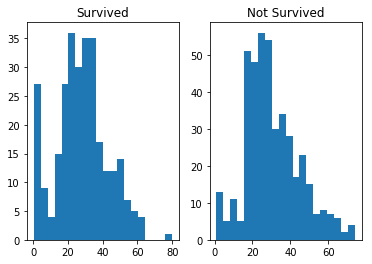

In [14]:
plt.subplot(1,2,1)
plt.hist(df["Age"][(df["Age"].notnull())&(df["Survived"]==1)],bins=20)
plt.title("Survived")

plt.subplot(1,2,2)
plt.hist(df["Age"][(df["Age"].notnull())&(df["Survived"]==0)],bins=20)
plt.title("Not Survived")

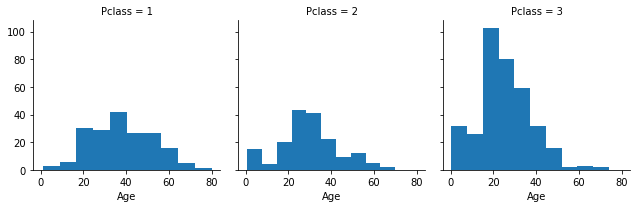

In [15]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Pclass").map(plt.hist,"Age")

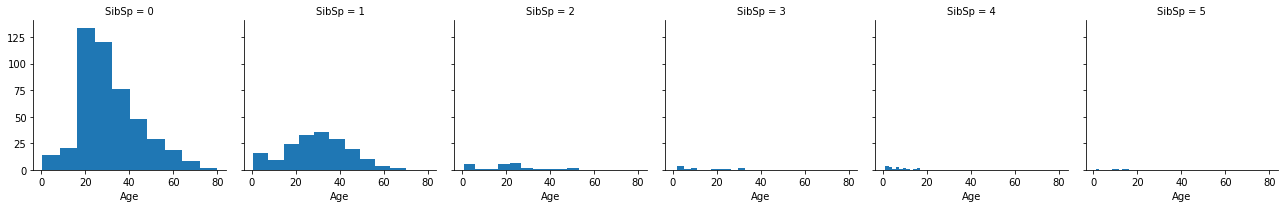

In [16]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="SibSp").map(plt.hist,"Age")

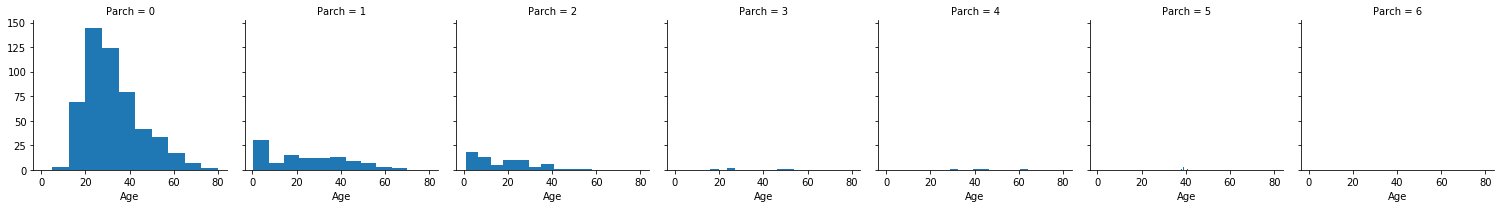

In [17]:
g=sns.FacetGrid(df[df["Age"].notnull()],col="Parch").map(plt.hist,"Age")

In [18]:
index_age=df[df["Age"].isnull()].index.values
median=df["Age"][df["Age"].notnull()].median()
for i in index_age: 
    Pclass,Parch,SibSp=df.loc[i,"Pclass"],df.loc[i,"Parch"],df.loc[i,"SibSp"]
    subset=df["Age"][(df["Pclass"]==Pclass)&(df["Parch"]==Parch)&(df["SibSp"]==SibSp)]
    if subset.any():
        median_s=int(subset.median())
        df.loc[i,"Age"]=median_s
    else:
        df.loc[i,"Age"]=median   

In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,AgeGroup,FareGroup,SurvivorsTicket,DeckKnown,Title,Size,FSize
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,"(20, 30]","[0, 25)",0,0,Mr,1,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,C,"(30, 40]","[50, 75)",0,1,Mrs,1,Small
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,"(20, 30]","[0, 25)",0,0,Miss,0,Single
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,C,"(30, 40]","[50, 75)",0,1,Mrs,1,Small
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,"(30, 40]","[0, 25)",0,0,Mr,0,Single


In [20]:
df.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,SurvivorsTicket,DeckKnown,Size
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.036312,-0.057527,-0.001652,0.012658,0.020145,0.019919,-0.040143
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.049666,-0.035322,0.081629,0.257307,0.382875,0.316912,0.016639
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.400485,0.083081,0.018443,-0.549500,-0.347558,-0.725541,0.065997
Sex,0.042939,-0.543351,0.131900,1.000000,0.090571,-0.114631,-0.245489,-0.182333,-0.206555,-0.140391,-0.200988
Age,0.036312,-0.049666,-0.400485,0.090571,1.000000,-0.252221,-0.185899,0.117799,-0.037683,0.268207,-0.265257
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.252221,1.000000,0.414838,0.159651,0.105438,-0.040460,0.890712
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.185899,0.414838,1.000000,0.216225,0.259257,0.036987,0.783111
Fare,0.012658,0.257307,-0.549500,-0.182333,0.117799,0.159651,0.216225,1.000000,0.478071,0.482075,0.217138
SurvivorsTicket,0.020145,0.382875,-0.347558,-0.206555,-0.037683,0.105438,0.259257,0.478071,1.000000,0.330154,0.201584
DeckKnown,0.019919,0.316912,-0.725541,-0.140391,0.268207,-0.040460,0.036987,0.482075,0.330154,1.000000,-0.009175


### Exploratory visualisation

In [21]:
features=["Sex","Pclass","FareGroup","Deck","SibSp","Parch","Embarked","SurvivorsTicket",\
          "DeckKnown","Title","FSize"]

In [22]:
d={}
for f in features:
    temp=df.groupby(["Survived",f]).size()
    d[f]=pd.concat([temp[0],temp[1]],axis=1).fillna(0)

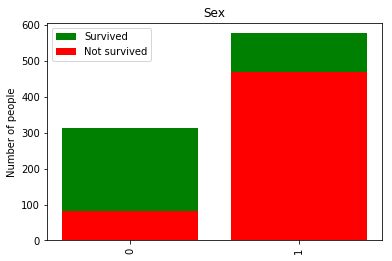

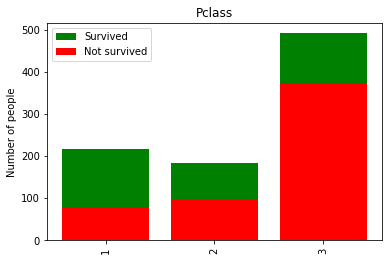

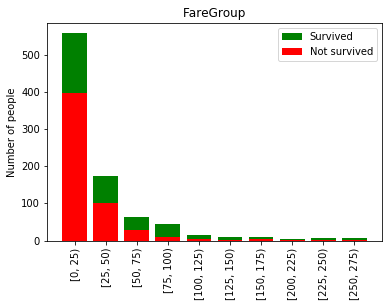

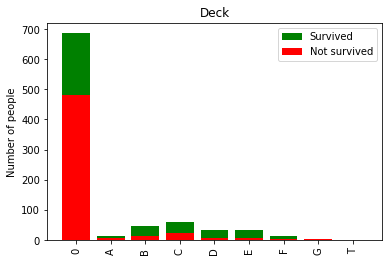

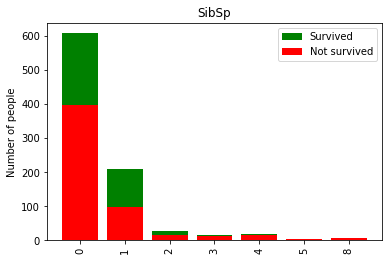

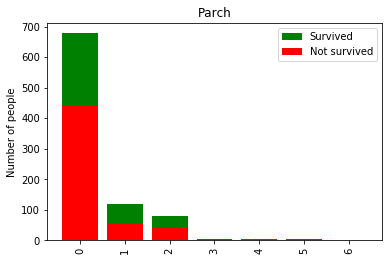

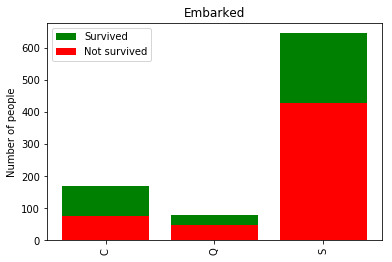

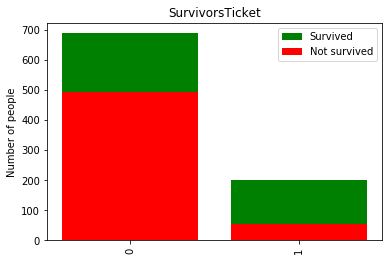

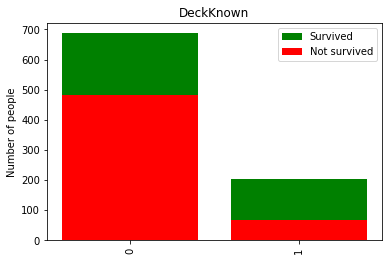

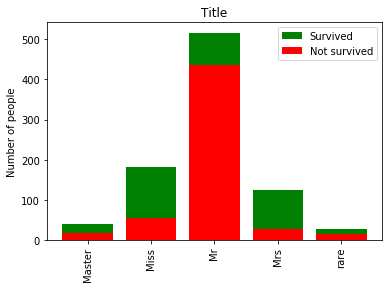

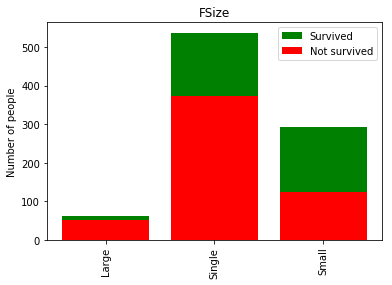

In [23]:
for f in features:
    plt.bar(np.arange(len(d[f][1])),d[f][1],bottom=d[f][0],label="Survived",color="g")
    plt.bar(np.arange(len(d[f][0])),d[f][0],label="Not survived",color="r")
    plt.xticks(np.arange(len(d[f][0])),d[f].index.values,rotation=90)
    plt.ylabel("Number of people")
    plt.title(f)
    plt.legend()
    plt.show()
    

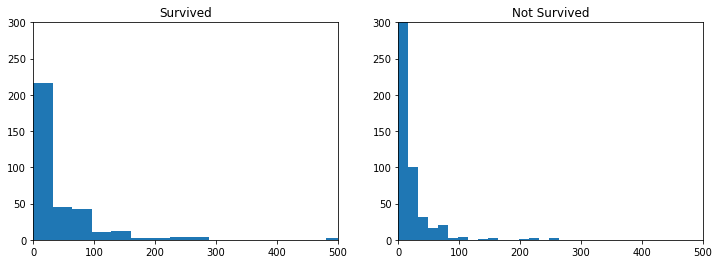

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df["Fare"][(df["Survived"]==1)],bins=16)
plt.title("Survived")
plt.axis([0,500,0,300])

plt.subplot(1,2,2)
plt.hist(df["Fare"][(df["Survived"]==0)],bins=16)
plt.title("Not Survived")
plt.axis([0,500,0,300])
plt.show()

### Drop features and get dummies

In [25]:
df.drop(labels=["Name","PassengerId","Ticket","Cabin","FareGroup","AgeGroup","Deck",\
               "SibSp","Parch"],axis=1,inplace=True)

In [26]:
df=pd.get_dummies(df,columns=["Pclass","Embarked","FSize","Title"])

In [27]:
df.head()

,Survived,Sex,Age,Fare,SurvivorsTicket,DeckKnown,Size,Pclass_1,Pclass_2,Pclass_3,...,Embarked_Q,Embarked_S,FSize_Large,FSize_Single,FSize_Small,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_rare
0,0,1,22.0,7.2500,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,1,0,38.0,71.2833,0,1,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0,26.0,7.9250,0,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0
3,1,0,35.0,53.1000,0,1,1,1,0,0,...,0,1,0,0,1,0,0,0,1,0
4,0,1,35.0,8.0500,0,0,0,0,0,1,...,0,1,0,1,0,0,0,1,0,0


### Machine learning

In [28]:
X_full=df.drop(labels=["Survived"],axis=1)
y_full=df["Survived"]
X_train,X_test,y_train,y_test=train_test_split(X_full,y_full,test_size=0.3,random_state=42)

In [29]:
kfold=StratifiedKFold(n_splits=10)

In [57]:
tree=DecisionTreeClassifier()
svm=SVC()
adaboost=AdaBoostClassifier()
rf=RandomForestClassifier()
neigh=KNeighborsClassifier()
nb=GaussianNB()
xgb=XGBClassifier()
logr=LogisticRegression()

In [58]:
classifiers=[tree,svm,adaboost,rf,neigh,nb,xgb,logr]

In [59]:
outcomes={}
names=[]
mean_accuracy=[]
std=[]
for c in classifiers:
    outcomes[c]=cross_val_score(c,X_full,y_full,cv=kfold,scoring="accuracy",verbose=1)
    names.append(c.__class__.__name__)
    mean_accuracy.append(outcomes[c].mean())
    std.append(outcomes[c].std())
    

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [60]:
clf_results=pd.DataFrame({"Classifier":names,"Mean accuracy":mean_accuracy,"Standard Deviation":std})

In [61]:
clf_results

,Classifier,Mean accuracy,Standard Deviation
0,DecisionTreeClassifier,0.796912,0.044731
1,SVC,0.743166,0.038206
2,AdaBoostClassifier,0.827263,0.034385
3,RandomForestClassifier,0.819372,0.029114
4,KNeighborsClassifier,0.719558,0.037039
5,GaussianNB,0.802579,0.028428
6,XGBClassifier,0.831694,0.038362
7,LogisticRegression,0.832843,0.028203


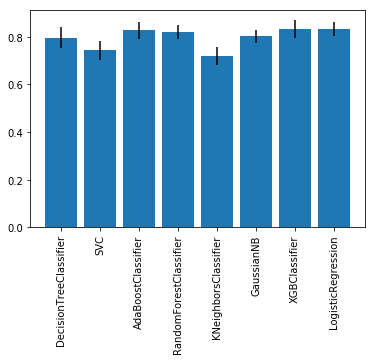

In [62]:
plt.bar(np.arange(len(clf_results)),clf_results["Mean accuracy"],yerr=clf_results["Standard Deviation"])
plt.xticks(np.arange(len(clf_results)),clf_results["Classifier"],rotation=90)
plt.show()

### Parameter tuning

In [115]:
tuning_results={}
def do_tune(clf_single,parameters,name):
    clf=GridSearchCV(clf_single,parameters,cv=kfold,scoring="accuracy",verbose=1,n_jobs=-1)
    clf.fit(X_full,y_full)
    tuning_results[name]=[clf.best_score_,clf.best_params_,clf.best_estimator_]
    return

#### AdaBoost

In [105]:
parameters_AB={"learning_rate":[0.1,0.2,0.4,1],"n_estimators":[50],"base_estimator":[DecisionTreeClassifier()],"algorithm":\
              ["SAMME","SAMME.R"]}
do_tune(AdaBoostClassifier(random_state=42),parameters_AB,"adaboost")

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   25.7s finished


In [106]:
tuning_results["adaboost"]

[0.82491582491582494,
 {'algorithm': 'SAMME.R',
  'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'),
  'learning_rate': 0.2,
  'n_estimators': 50}]

#### Random Forest Classifier

In [94]:
parameters_RF = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
do_tune(RandomForestClassifier(),parameters_RF,"rf")

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  7.6min finished


In [96]:
tuning_results["rf"]

[0.83726150392817056,
 {'bootstrap': False,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': 10,
  'min_samples_leaf': 3,
  'min_samples_split': 10,
  'n_estimators': 100}]

#### Logistic Regression

In [108]:
parameters_logr={"C":[0.001,0.01,0.1,1,10,100,1000]}
do_tune(logr,parameters_logr,"logr")

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   26.2s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   26.2s finished


In [109]:
tuning_results["logr"]

[0.83389450056116721, {'C': 10}]

#### XGBoost

In [113]:
parameters_xgb={"max_depth":[3,5,7,9,11,13,17,20],"learning_rate":[0.01,0.1]}
do_tune(xgb,parameters_xgb,"xgb")

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   26.4s finished


In [118]:
tuning_results["xgb"]

KeyError: 'xgb'

In [116]:
pd.DataFrame(tuning_results)

""


In [117]:
tuning_results

{}

### Output

In [114]:
test["pred"]=do_classify(SVC(random_state=42),parameters_svm,X_full,y_full,X_real,[0])


['Sex', 'Fare', 'Parch', 'SurvivorsTicket', 'DeckKnown']
0.911335578002
0.79797979798
{'kernel': 'rbf', 'C': 1.4, 'gamma': 1.3}


In [ ]:
submission=test[["PassengerId","pred"]]
submission.columns=["PassengerId","Survived"]
submission.to_csv("FirstSubmission.csv",index=False)